In [1]:
import numpy as np
from loadmodules import *
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.mixture import GaussianMixture

from numba import njit, config
config.THREADING_LAYER = 'omp'

%matplotlib inline

In [17]:
simulation_1 = './Au6_lvl4_d8ad_testchanges/output/'
simulation_2 = './Au6_lvl4_d8ad_nottconst/output/'

sims = [simulation_1, simulation_2]

In [18]:
def mask_equal_to_previous(arr):
    mask = np.ones(len(arr), dtype=bool)
    mask[1:] = arr[1:] != arr[:-1]
    return mask

def B(x):
    return sp.special.erf(x) * 2.*x*np.exp(-x**2)/np.sqrt(np.pi)

@njit(parallel=True)
def velocity_dispersion(radius, parts_radius, starparts, s_data_age, s_data_vel, s_data_type):
    # Select particles within the given radius
    within_radius = parts_radius[starparts][s_data_age > 0.] < radius
    if within_radius.sum() >= 48:
        velocities = np.sqrt(np.sum(s_data_vel[starparts][s_data_age > 0.][within_radius]**2, axis=1))
    # if not enough stars, use dark matter particles
    else:
        mask_dm = (s_data_type != 4) * (s_data_type != 0)
        within_radius = parts_radius[mask_dm] < radius
        velocities = np.sqrt(np.sum(s_data_vel[mask_dm][within_radius]**2, axis=1))

    # Calculate the velocity dispersion
    if velocities.size == 0:
        return 0.0
    # Avoid division by zero
    else:
        return np.std(velocities)

In [19]:
def get_redshift(s, lookbacktime):
    a_test = np.linspace(1e-2,1,500)
    a_analogous = []
    for t in lookbacktime:
        a_analogous.append(a_test[np.absolute(s.cosmology_get_lookback_time_from_a(a_test, is_flat=True) - t).argmin()])
    a_analogous = np.array(a_analogous)
    return 1/a_analogous - 1

def calculate_cfr_and_age_distribution(sim, snapshot=127, nbins=100, min_range=0., max_range=13.):
    sf = load_subfind(snapshot, dir=sim, hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
    s = gadget_readsnap(snapshot, snappath=sim, subfind=sf, hdf5=True, loadonlyhalo=0)
    s.calc_sf_indizes( sf )
    galrad = 0.75 * sf.data['frc2'][0]
    s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

    print('Redshift of the simulation: {:2.2f}'.format(s.redshift))

    Gcosmo = 43.
    starparts = s.data['age']>0.
    
    kinetic_energy = np.sum(s.data['vel']**2, axis=1)

    orbital_energy = s.data['pot'] + 0.5 * kinetic_energy
    orbital_energy /= 1e5
    e_max = orbital_energy.max()
    orbital_energy -= e_max
    Lz = np.cross( s.data['pos'], (s.data['vel'] ) )[:,0]
    Lz *= np.sign(np.nanmedian(Lz))

    isort_parts = np.argsort(s.r())
    revert_sort = np.argsort(isort_parts)
    cummass = np.cumsum(s.data['mass'][isort_parts])
    Vc_parts = np.sqrt(Gcosmo*cummass[revert_sort]/s.r())

    # Energy of circular orbits at increasing radii
    Ecirc = 0.5*Vc_parts[isort_parts]**2 + s.data['pot'][isort_parts]
    Ecirc /= 1e5
    Ecirc -= e_max
    
    isort_parts = np.argsort(s.r())
    revert_sort = np.argsort(isort_parts)
    cummass = np.cumsum(s.data['mass'][isort_parts])
    Vc_parts = np.sqrt(Gcosmo*cummass[revert_sort]/s.r())

    mask = mask_equal_to_previous(s.r()[isort_parts][~np.isinf(Ecirc)])

    r_test = np.logspace(-4.5, np.log10(s.r().max()), 500)
    Ecirc_f = sp.interpolate.PchipInterpolator(s.r()[isort_parts][~np.isinf(Ecirc)][mask], Ecirc[~np.isinf(Ecirc)][mask])
    Vc_f = sp.interpolate.PchipInterpolator(s.r()[isort_parts][~np.isinf(Ecirc)][mask], Vc_parts[isort_parts][~np.isinf(Ecirc)][mask])
    
    mask_clusters_initial = ((s.data['incl'][starparts] > 0 ) * (s.r()[s.data['type']==4][starparts] <= galrad))
    
    idx = np.argmin(np.abs(orbital_energy[s.data['type']==4][starparts][:,np.newaxis] - Ecirc_f(r_test)), axis=1)
    rc = r_test[idx]
    vc = Vc_f(rc)
    Lzmax = rc*vc
    circ_param = Lz[s.data['type']==4][starparts]/Lzmax
    circ_param[np.abs(circ_param) > 1.5] = 1.5 * np.sign(circ_param[np.abs(circ_param) > 1.5])  # Limit extreme values

    # Build feature array: [ε, Energy]
    X = np.vstack((circ_param, orbital_energy[s.data['type']==4][starparts])).T

    # Fit GMM
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
    gmm.fit(X)

    # Predict cluster memberships
    decomposition = gmm.predict(X)
    if np.median(circ_param[decomposition==0]) > np.median(circ_param[decomposition==1]):
        print('Label 1 is GC candidate', np.median(circ_param[decomposition==0]), np.median(circ_param[decomposition==1]))
        gc_label = 1
    else:
        print('Label 0 is GC candidate', np.median(circ_param[decomposition==0]), np.median(circ_param[decomposition==1]))
        gc_label = 0
    
    decomposition = np.repeat(decomposition[mask_clusters_initial], s.data['incl'][starparts][mask_clusters_initial])

    mask_gc = (decomposition == gc_label)
    cluster_masses = s.data['mclt'][starparts][mask_clusters_initial].flatten()
    init_cluster_masses = s.data['imcl'][starparts][mask_clusters_initial].flatten()
    
    not_empty_clusters = (init_cluster_masses>0.)

    cluster_masses = cluster_masses[not_empty_clusters]
    init_cluster_masses = init_cluster_masses[not_empty_clusters]

    clusters_formtime = np.repeat(s.data['age'][starparts][mask_clusters_initial], s.data['incl'][starparts][mask_clusters_initial])
    clusters_age = s.cosmology_get_lookback_time_from_a(clusters_formtime, is_flat=True) - s.cosmology_get_lookback_time_from_a(s.time, is_flat=True)

    cfr_all, _ = np.histogram(clusters_age, bins=nbins, range=[min_range,max_range], weights=1e10*init_cluster_masses/((max_range-min_range)/nbins) /1e9)
    cfr_gc, _ = np.histogram(clusters_age[mask_gc * (1e10*init_cluster_masses > 1e5)], bins=nbins, range=[min_range,max_range],
                             weights=1e10*init_cluster_masses[mask_gc * (1e10*init_cluster_masses > 1e5)]/((max_range-min_range)/nbins) /1e9)
    age_all, _ = np.histogram(clusters_age[(cluster_masses>0.)], bins=nbins, range=[min_range, max_range], density=True)
    age_gc, bins = np.histogram(clusters_age[mask_gc * (cluster_masses>0.) * (1e10*init_cluster_masses > 1e5)], bins=nbins, range=[min_range, max_range], density=True)
    redshit_bins = get_redshift(s, bins)
    return cfr_all, cfr_gc, age_all, age_gc, bins, redshit_bins

In [ ]:
nbins = 40
min_range = 0
max_range = 14

In [20]:
cluster_formation_rate_all = []
cluster_formation_rate_gc = []
age_distribution_surviving_all = []
age_distribution_surviving_gc = []

snapshot = 127
for sim in sims:
    cfr_all, cfr_gc, age_all, age_gc, bins, redshift_bins = calculate_cfr_and_age_distribution(sim, snapshot=snapshot, nbins=nbins, min_range=min_range, max_range=max_range)
    cluster_formation_rate_all.append(cfr_all)
    cluster_formation_rate_gc.append(cfr_gc)
    age_distribution_surviving_all.append(age_all)
    age_distribution_surviving_gc.append(age_gc)

/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02146396636962891
Found 1406988 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
Label 0 is GC candidate 0.0994175131764139 0.9265690268796428


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.021417133510112762
Found 1609776 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.00
Label 0 is GC candidate 0.1771210644438501 0.9272650545824792


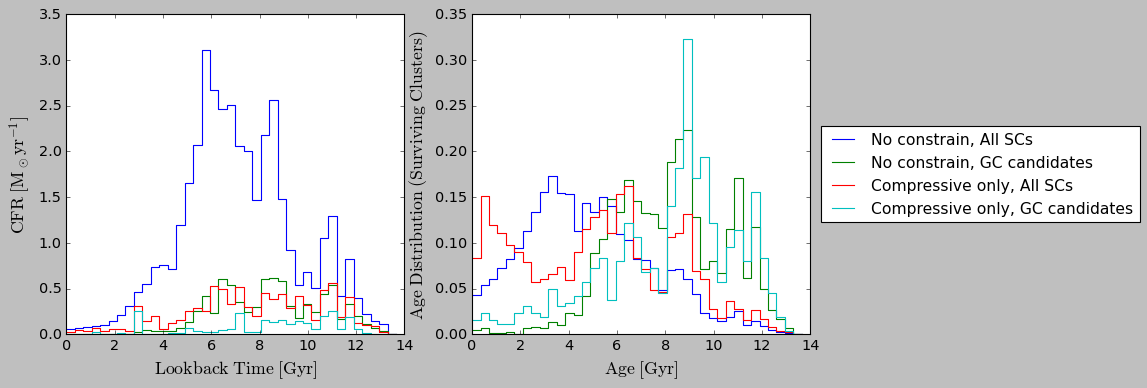

In [21]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].step(bins[:-1], cluster_formation_rate_all[1], where='post', label='No tidal constrain, All SCs')
ax[0].step(bins[:-1], cluster_formation_rate_gc[1], where='post', label='No tidal constrain, GC candidates')
ax[0].step(bins[:-1], cluster_formation_rate_all[0], where='post', label='Compressive only, All SCs')
ax[0].step(bins[:-1], cluster_formation_rate_gc[0], where='post', label='Compressive only, GC candidates')
ax[0].set_ylabel(r'$\rm{CFR \; [M_\odot yr^{-1}]}$', fontsize=16)
ax[0].set_xlabel(r'$\rm{Lookback \; Time \; [Gyr]}$', fontsize=16)
# ax[0].set_yscale('log')
ax[0].tick_params(axis='both', which='major', labelsize=13)

ax[1].step(bins[:-1], age_distribution_surviving_all[1], where='post', label='No constrain, All SCs')
ax[1].step(bins[:-1], age_distribution_surviving_gc[1], where='post', label='No constrain, GC candidates')
ax[1].step(bins[:-1], age_distribution_surviving_all[0], where='post', label='Compressive only, All SCs')
ax[1].step(bins[:-1], age_distribution_surviving_gc[0], where='post', label='Compressive only, GC candidates')
ax[1].set_ylabel(r'$\rm{Age \; Distribution \; (Surviving \;Clusters)}$', fontsize=16)
ax[1].set_xlabel(r'$\rm{Age \; [Gyr]}$', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=13)
# ax[1].set_yscale('log')
ax[1].legend(fontsize=14, bbox_to_anchor=(1.01, 0.5), loc='center left')

In [14]:
cfr_all, cfr_gc, age_all, age_gc, bins, redshift_bins = calculate_cfr_and_age_distribution(simulation_1, snapshot=121, nbins=nbins, min_range=min_range, max_range=max_range)

/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.021735294163227083
Found 2200659 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.07
Label 0 is GC candidate -1.1482577981393791 0.8740117455001609


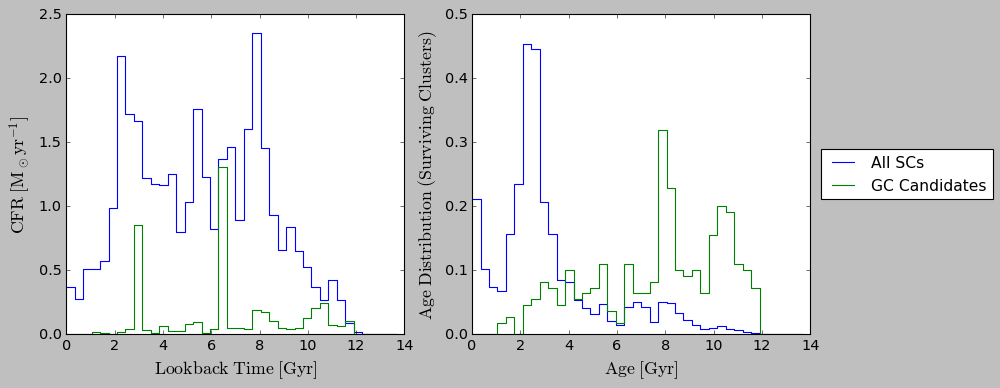

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].step(bins[:-1], cfr_all, where='post', label='All SCs')
ax[0].step(bins[:-1], cfr_gc*5, where='post', label='GC Candidates')
ax[0].set_ylabel(r'$\rm{CFR \; [M_\odot yr^{-1}]}$', fontsize=16)
ax[0].set_xlabel(r'$\rm{Lookback \; Time \; [Gyr]}$', fontsize=16)
# ax[0].set_yscale('log')
ax[0].tick_params(axis='both', which='major', labelsize=13)

ax[1].step(bins[:-1], age_all, where='post', label='All SCs')
ax[1].step(bins[:-1], age_gc, where='post', label='GC Candidates')
ax[1].set_ylabel(r'$\rm{Age \; Distribution \; (Surviving \;Clusters)}$', fontsize=16)
ax[1].set_xlabel(r'$\rm{Age \; [Gyr]}$', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=13)
# ax[1].set_yscale('log')
ax[1].legend(fontsize=14, bbox_to_anchor=(1.01, 0.5), loc='center left')